# Notebook Version 2

I made a condensed, and more flexible notebook from out initial. It contains the same processing, but not ass much intermittent reporting making navigation easier. One can of course add code where additional summary reports or graphics is needed. In addition, if the functions generating these reports are in a separate file, this notebook can stay condensed.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency



In [3]:
from helpers import outliers_IQR, outliers_z_score, outliers_min_max, handle_outliers, fix_obesity

In [4]:
diabetes = pd.read_csv('diabetes.csv')

binary_features = ['Obesity', 'TCep', 'Polydipsia', 'Sudden Weight Loss', 'Weakness',
                   'Polyphagia', 'Genital Thrush', 'Visual Blurring', 'Itching',
                   'Irritability', 'Delayed Healing', 'Partial Paresis', 'Muscle Stiffness', 'Alopecia']
cat_features = ['Race',	'Occupation',	'GP']
num_features = ['Age',	'Height',	'Weight',	'Temperature',	'Urination']
one_hot_features = {} # for future use
diabetes.info()
print("Found:", len(cat_features+binary_features+num_features)+1) # +1 for Gender
print("In DS:", diabetes.shape[1]-1) # -1 for target


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 534 non-null    float64
 1   Gender              542 non-null    object 
 2   Race                537 non-null    object 
 3   Occupation          534 non-null    object 
 4   GP                  539 non-null    object 
 5   Height              538 non-null    float64
 6   Weight              541 non-null    float64
 7   Obesity             538 non-null    object 
 8   Temperature         546 non-null    float64
 9   Urination           532 non-null    float64
 10  TCep                546 non-null    object 
 11  Polydipsia          540 non-null    object 
 12  Sudden Weight Loss  530 non-null    object 
 13  Weakness            541 non-null    object 
 14  Polyphagia          544 non-null    object 
 15  Genital Thrush      538 non-null    object 
 16  Visual B

## Uniform formatting

In [5]:

# Converts all binary features to lower case
for f in binary_features:
   diabetes[f] = diabetes[f].str.lower()

# Converts all binary features to ints, preserving Na-s
diabetes = diabetes.replace({'yes':1, 'no':0}) 

## Duplicates

We identify duplicates and delete them. We assume they are caused by an error in the data collection, and it's unlikely that there are two correct instances with the exact same values.  



In [6]:
diabetes = diabetes.drop_duplicates(keep='first')

# Summary reports

# Preliminary Data analysis

# Train - Test split
We split as early as possible to avoid cross contamination of information from the test set.

In [7]:
train_proportion = 0.8
train_idx = np.random.choice(diabetes.index, int(train_proportion*len(diabetes.index)), replace=False)
train = diabetes.loc[train_idx]
test = diabetes.drop(train_idx)
assert len(diabetes.index) == len(train.index) + len(test.index)

## Outliers

In [8]:
age_min, age_max = outliers_IQR(train, 'Age')
age_min2, age_max2 = outliers_z_score(train, 'Age')

print("IQR:", age_min, age_max)
print("Z-score:", age_min2, age_max2)
outliers_min_max(train, 'Age', age_min, age_max)

IQR: 12.0 84.0
Z-score: -14.622750386924096 112.84935137214578


,Age,Gender,Race,Occupation,GP,Height,Weight,Obesity,Temperature,Urination,...,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes
137,155.0,Male,White,Judge,Dr. Mayson Harris,167.12,65.05,0.0,36.99,1.58,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
20,90.0,Female,White,Retired,Dr. Andreea Gregory,165.87,67.48,0.0,36.86,NaN,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,Positive
59,85.0,Male,White,Retired,Dr. Arda O'Brien,185.81,72.88,0.0,36.70,2.53,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,Positive
399,-22.0,Male,White,Dentist,Dr. Ingrid Mata,174.25,71.10,0.0,36.96,2.63,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,Positive
449,377.0,Male,White,Consultant,Dr. Angharad Grainger,169.31,68.32,0.0,37.23,1.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive


In [9]:

print("Before removal of outliers:", train.shape)
train = handle_outliers(train)
test = handle_outliers(test)
print("After removal of outliers:", train.shape)

# How does it look now? All min max values sensible ...
train.describe()

Before removal of outliers: (416, 24)
After removal of outliers: (416, 24)


,Age,Height,Weight,Obesity,Temperature,Urination,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia
count,403.000000,413.000000,413.000000,411.000000,416.000000,404.000000,416.000000,412.000000,404.000000,412.000000,415.000000,408.000000,412.000000,411.000000,412.000000,410.000000,407.000000,406.000000,409.000000
mean,48.213400,160.804620,69.542567,0.155718,37.005337,2.238069,0.432692,0.444175,0.413366,0.589806,0.469880,0.220588,0.461165,0.491484,0.254854,0.460976,0.439803,0.374384,0.337408
std,12.083627,37.339118,15.778282,0.363029,0.193562,0.678221,0.496046,0.497478,0.493048,0.492467,0.499694,0.415152,0.499096,0.500537,0.436309,0.499084,0.496974,0.484561,0.473405
min,16.000000,1.456000,40.350000,0.000000,36.460000,0.860000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,160.800000,57.930000,0.000000,36.880000,1.607500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,169.150000,67.110000,0.000000,37.010000,2.155000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,57.000000,175.910000,80.120000,0.000000,37.140000,2.840000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,90.000000,194.240000,125.950000,1.000000,37.600000,3.430000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Missing data

In [10]:
def check_missing_data(df):
  print(df.isna().sum().sort_values(ascending=False))
  print(df.isna().mean().sort_values(ascending=False))
  print("Total number of missing data:", df.isna().sum().sum())
  print("Percentage of missing data:", df.isna().mean().mean())
  print("Samples with at least one missing value:", len(df[df.isnull().any(axis=1)]))
  print("Percentage samples with at least one missing value:", len(df[df.isnull().any(axis=1)])/len(df))

check_missing_data(train)

Age                   13
Urination             12
Sudden Weight Loss    12
Muscle Stiffness      10
Occupation             9
Partial Paresis        9
Genital Thrush         8
Alopecia               7
Race                   7
Delayed Healing        6
Obesity                5
Itching                5
GP                     5
Irritability           4
Visual Blurring        4
Weakness               4
Polydipsia             4
Gender                 3
Weight                 3
Height                 3
Polyphagia             1
TCep                   0
Temperature            0
Diabetes               0
dtype: int64
Age                   0.031250
Urination             0.028846
Sudden Weight Loss    0.028846
Muscle Stiffness      0.024038
Occupation            0.021635
Partial Paresis       0.021635
Genital Thrush        0.019231
Alopecia              0.016827
Race                  0.016827
Delayed Healing       0.014423
Obesity               0.012019
Itching               0.012019
GP             

In [11]:
# missing more than 2
for i in train[train.isna().sum(axis=1) > 2].index:
  print(train.loc[i,])

Age                              34.0
Gender                         Female
Race                            White
Occupation                    Dentist
GP                    Dr. Albie Colon
Height                         156.04
Weight                          47.94
Obesity                           0.0
Temperature                      37.1
Urination                        2.79
TCep                                0
Polydipsia                        NaN
Sudden Weight Loss                NaN
Weakness                          1.0
Polyphagia                        0.0
Genital Thrush                    0.0
Visual Blurring                   0.0
Itching                           0.0
Irritability                      1.0
Delayed Healing                   0.0
Partial Paresis                   NaN
Muscle Stiffness                  1.0
Alopecia                          0.0
Diabetes                     Positive
Name: 187, dtype: object


### Derived Features

In [12]:
train = fix_obesity(train)
test = fix_obesity(test)

### Missing Binaries

In [13]:
train[binary_features] = train[binary_features].fillna(0)
test[binary_features] = test[binary_features].fillna(0)

### Missing Categorical

It makes no sense to consider 'Gender' as a binary feature where we can default it to 0. In addition, there might exist a gender bias in the data collection, and including it as missing might mitigate or reveal it later.

In [14]:
# we want to fill early s.t. there are no Na-s beyond this point
train[cat_features + ['Gender']] = train[cat_features+ ['Gender']].fillna('MISSING') 
test[cat_features + ['Gender']] = test[cat_features+ ['Gender']].fillna('MISSING') 

### Missing numeric

In [15]:
# Fill Na-s with mean. 
train[num_features] = train[num_features].fillna(train[num_features].mean())
# We fill the test data with the mean of the train data, making the test set indepentent of each others
test[num_features] = test[num_features].fillna(train[num_features].mean())

### Testing for remaining Na-s

In [16]:
assert train.isna().sum().sum() == 0, f'train data still containts {train.isna().sum().sum()} Na-s'
assert test.isna().sum().sum() == 0, f'test data still containts {test.isna().sum().sum()} Na-s'


Henceforth, we may assume both train and test data contains no Na-s, drastically simplifying the rest of the code. For online learning, we should perhaps implement the code in this section as a function so that we can apply it on new cases continuously.

## Encoding

In [17]:
gender_dummies = pd.get_dummies(train['Gender'], prefix='gender')
train = train.join(pd.get_dummies(train['Gender'], prefix='gender'))
test = test.join(pd.get_dummies(test['Gender'], prefix='gender'))

one_hot_features['Gender'] = list(gender_dummies.columns)

## Correlations

In [18]:
corr = train.corr(numeric_only=True)
#corr['Diabetes']
#sns.heatmap(corr)

# look at the smallest and largest in absolute value
cmap = 'coolwarm' # Added colour map as a variable for consistent plot style
corrs = corr.stack().loc[lambda x : (x < 1)].abs().sort_values()
print("Smallest:")
print(corrs[:20])
print("-------------------------------")
print("Largest:")
print(corrs[-20:])

corr.style.background_gradient(cmap=cmap).set_precision(2)

Smallest:
Height            Polyphagia          0.001770
Polyphagia        Height              0.001770
Genital Thrush    Temperature         0.003011
Temperature       Genital Thrush      0.003011
Height            Irritability        0.003019
Irritability      Height              0.003019
                  Temperature         0.004017
Temperature       Irritability        0.004017
TCep              Temperature         0.004281
Temperature       TCep                0.004281
Genital Thrush    Polydipsia          0.004806
Polydipsia        Genital Thrush      0.004806
Height            Temperature         0.006790
Temperature       Height              0.006790
TCep              Muscle Stiffness    0.007751
Muscle Stiffness  TCep                0.007751
Polyphagia        Temperature         0.007989
Temperature       Polyphagia          0.007989
gender_MISSING    Age                 0.008036
Age               gender_MISSING      0.008036
dtype: float64
-------------------------------
Lar

/var/folders/ps/_kmvj3_s5w5109d0211tgc9r0000gn/T/ipykernel_88480/3250011536.py:14: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap=cmap).set_precision(2)


,Age,Height,Weight,Obesity,Temperature,Urination,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,gender_Female,gender_MISSING,gender_Male
Age,1.00,0.02,0.13,0.14,-0.02,0.17,-0.04,0.14,0.05,0.24,0.27,0.08,0.42,0.26,0.20,0.22,0.22,0.29,0.30,-0.08,0.01,0.08
Height,0.02,1.00,0.17,-0.05,0.01,-0.09,0.07,-0.03,-0.06,0.06,-0.00,0.05,-0.01,0.04,-0.00,0.06,-0.01,0.03,0.03,-0.15,0.03,0.14
Weight,0.13,0.17,1.00,0.60,0.03,-0.02,-0.01,-0.03,0.03,-0.03,-0.07,0.10,0.02,0.02,0.11,-0.07,-0.10,0.01,0.17,-0.36,0.05,0.35
Obesity,0.14,-0.05,0.60,1.00,0.07,0.16,-0.03,0.05,0.19,0.03,0.01,0.06,0.13,-0.07,0.16,-0.08,0.02,0.14,0.04,-0.03,0.04,0.02
Temperature,-0.02,0.01,0.03,0.07,1.00,0.03,-0.00,0.05,0.06,-0.03,-0.01,0.00,-0.02,-0.05,-0.00,0.01,-0.04,-0.04,0.01,0.02,0.05,-0.03
Urination,0.17,-0.09,-0.02,0.16,0.03,1.00,-0.26,0.52,0.38,0.26,0.34,0.06,0.24,0.10,0.22,0.15,0.40,0.09,-0.12,0.33,0.02,-0.33
TCep,-0.04,0.07,-0.01,-0.03,-0.00,-0.26,1.00,-0.27,-0.18,-0.14,-0.15,-0.01,-0.12,-0.05,-0.14,-0.04,-0.17,-0.01,0.09,-0.22,-0.07,0.23
Polydipsia,0.14,-0.03,-0.03,0.05,0.05,0.52,-0.27,1.00,0.40,0.34,0.33,0.00,0.34,0.19,0.21,0.14,0.44,0.19,-0.30,0.33,0.04,-0.33
Sudden Weight Loss,0.05,-0.06,0.03,0.19,0.06,0.38,-0.18,0.40,1.00,0.26,0.24,0.07,0.08,0.01,0.15,0.08,0.24,0.09,-0.18,0.29,0.10,-0.30
Weakness,0.24,0.06,-0.03,0.03,-0.03,0.26,-0.14,0.34,0.26,1.00,0.24,0.02,0.32,0.33,0.14,0.35,0.30,0.29,0.12,0.14,0.01,-0.15


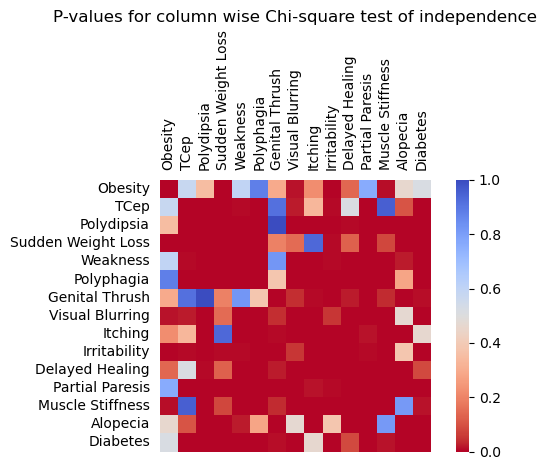

In [19]:
import matplotlib
from helpers import plot_chi_square_p_values

# reverse color as low p-value indicates strong dependence
plot_chi_square_p_values(train[binary_features + ['Diabetes']], kwargs={'cmap' : matplotlib.colormaps[cmap +'_r']})


Common sense can replace domain experts, in some cases - Roxana Pop, i.e. we should not use 'TCep' for our analysis (even though delayed healing might be correlated with aversion for tattoos)


In [20]:
from biseral_correlation import plot_point_biserial_correlation

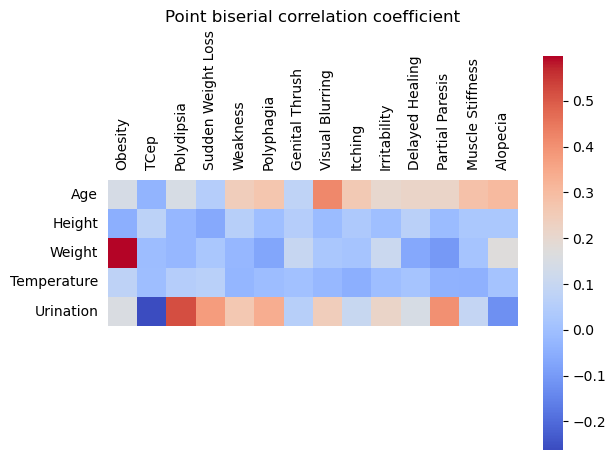

In [38]:
plot_point_biserial_correlation(train, cont=num_features, cat=binary_features, kwargs={'cmap' : cmap})

## Data exploration

In [22]:
# There are some interesting things to see in the categoricals ...
# Only one Black in entire data set ...
# This looks very much like a rich person data set ...
for c in cat_features:
  print(train.groupby(c, dropna=False).size())

#print(train['GP'].unique())

Race
Asian        8
Black        1
MISSING      7
White      400
dtype: int64
Occupation
Architect        29
Consultant       33
Dentist          27
Economist        31
Engineer         22
Entrepreneur     22
Journalist       22
Judge            34
Lawyer           25
MISSING           9
Manager          43
Retired         118
Student           1
dtype: int64
GP
Dr. Albie Colon          29
Dr. Alice Watson         19
Dr. Andreea Gregory      21
Dr. Angharad Grainger    19
Dr. Arda O'Brien         21
Dr. Cristiano Ayala      12
Dr. Dominic Farmer       22
Dr. Ingrid Mata          19
Dr. Jamil Walters        14
Dr. Joshua Riley         30
Dr. Kameron Lancaster    23
Dr. Kason Lloyd          15
Dr. Khalid Sellers       17
Dr. Korey Clay           27
Dr. Lina Beech           18
Dr. Lorelai York         16
Dr. Madison Guy          29
Dr. Mayson Harris        20
Dr. Nial Higgs           20
Dr. Orla Arellano        20
MISSING                   5
dtype: int64


Polydipsia
0.0    1.930602
1.0    2.629544
Name: Urination, dtype: float64


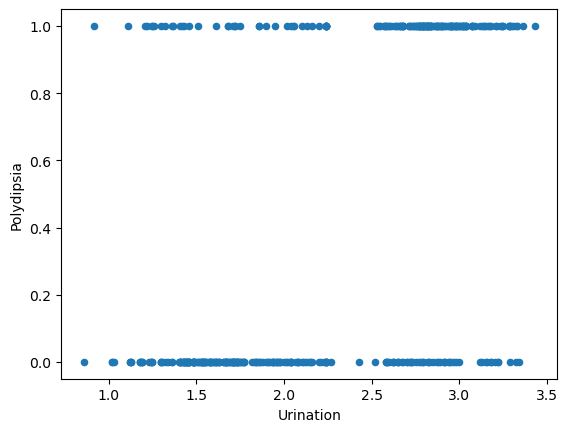

In [23]:
train.plot.scatter('Urination', 'Polydipsia')
print(train.groupby('Polydipsia')['Urination'].mean())

<Axes: ylabel='Frequency'>

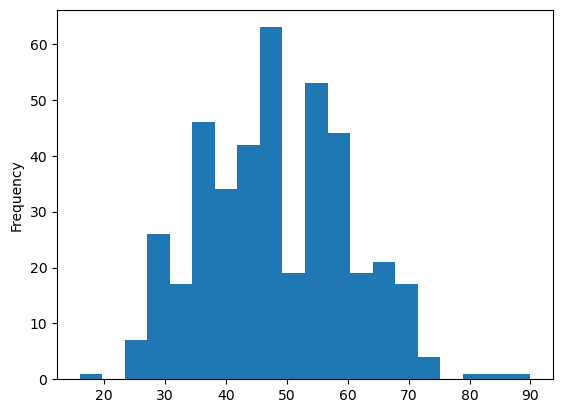

In [24]:
train['Age'].plot.hist(bins=20)

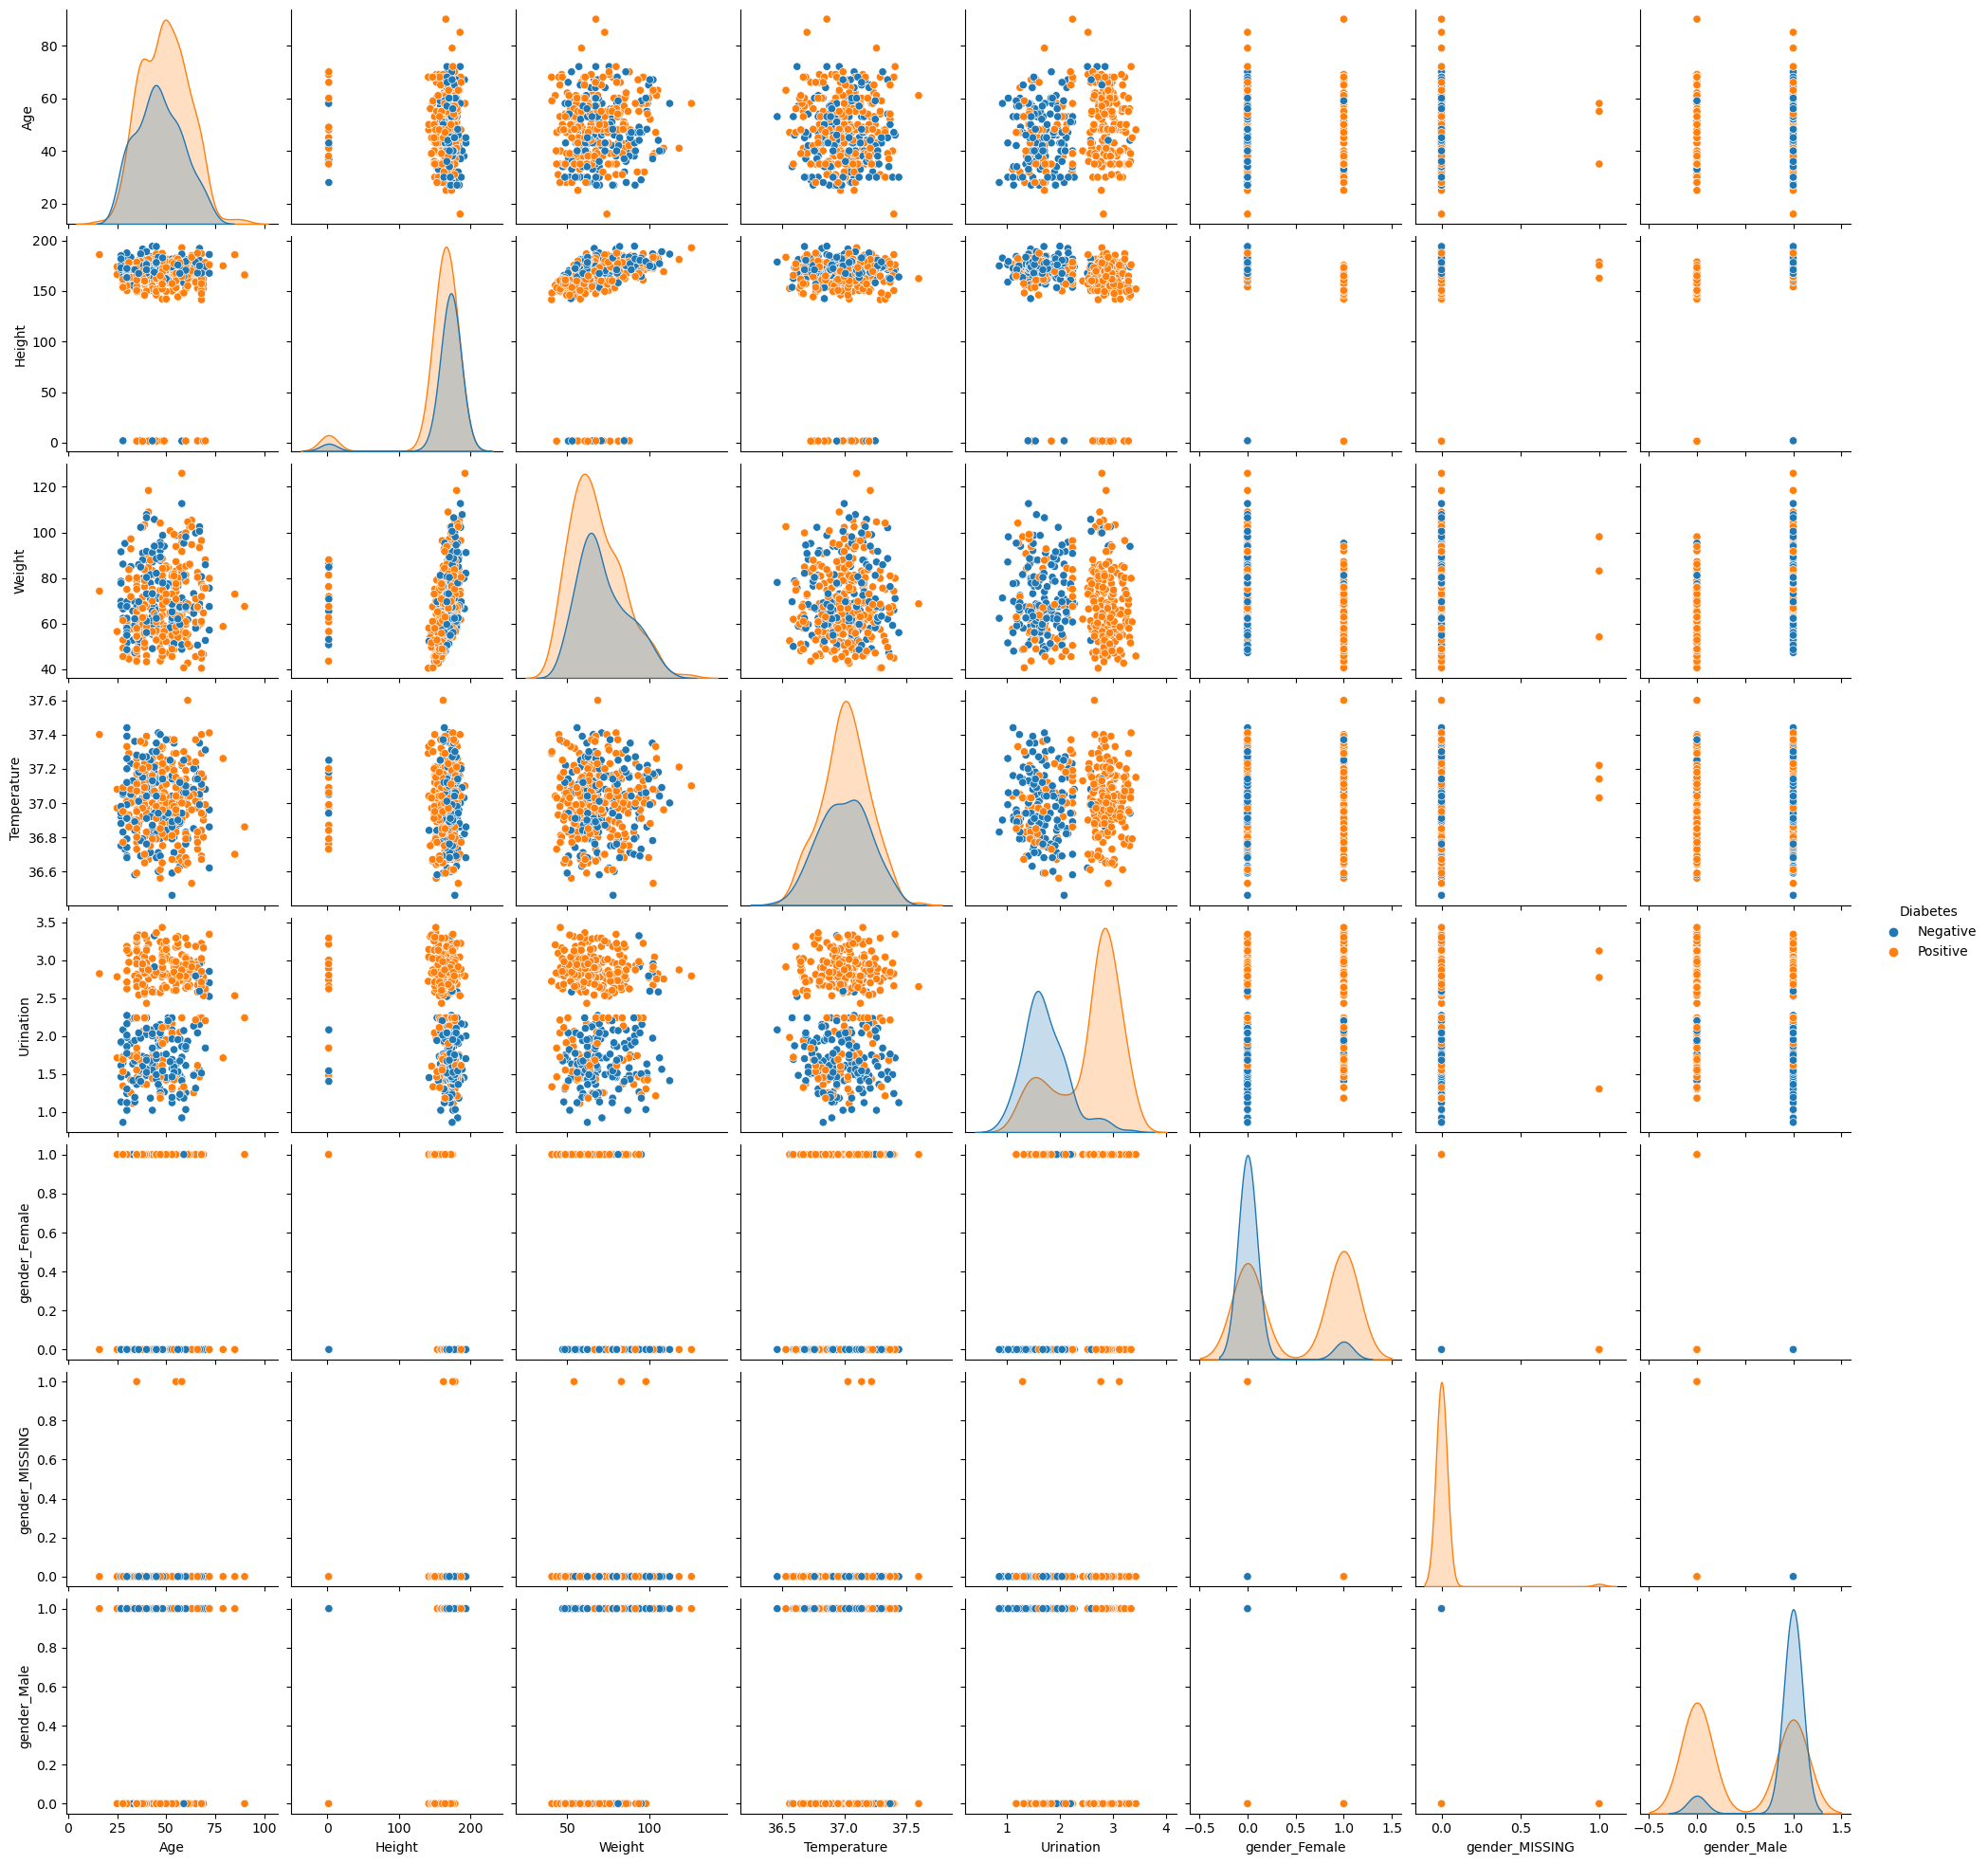

In [25]:
# After encoding, pair-plotting diabetes is messed up, because it tries to make 23*23 plots?
# need to drop the binaries from DF plotted.
train_plot = train.drop(binary_features , axis=1)

#diabetes_plot = train.drop('Gender', axis=1)
g = sns.pairplot(train_plot, hue='Diabetes')

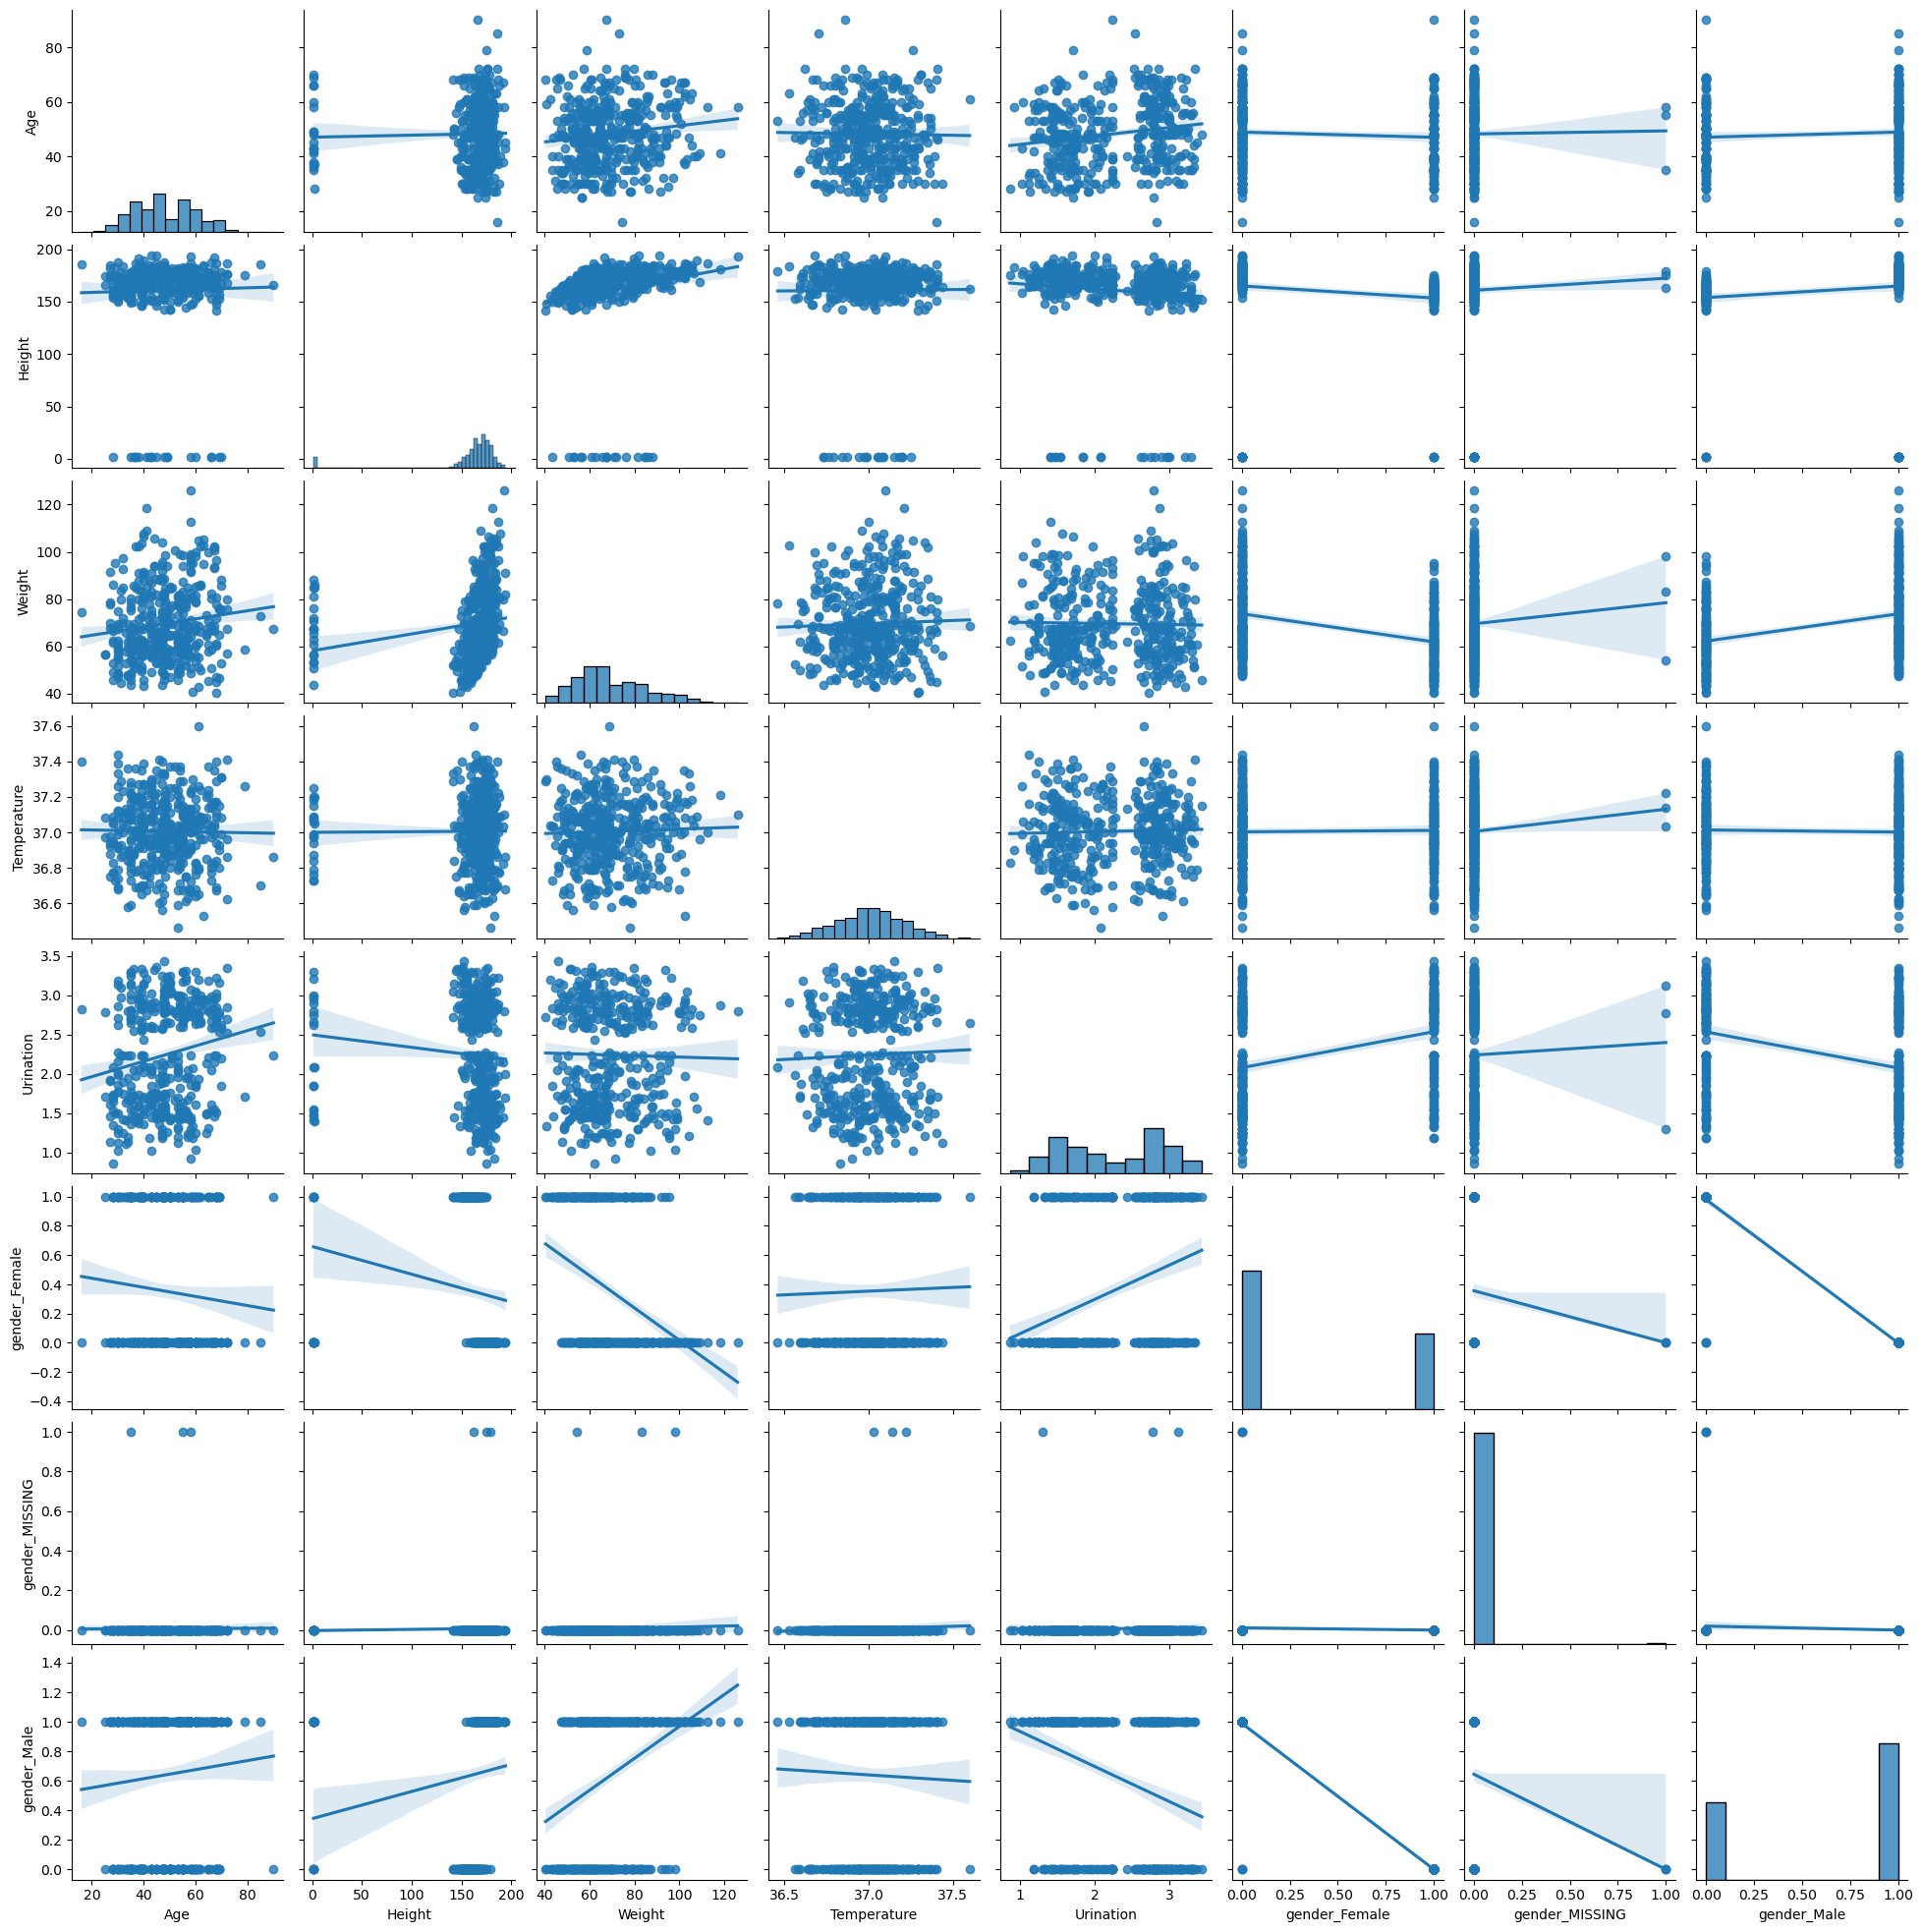

In [26]:
g = sns.pairplot(train_plot, kind='reg')

In [27]:
# Perhaps redundant given the chi-square plot earlier?
for f in binary_features:
  cross_tab = pd.crosstab(diabetes[f], diabetes['Diabetes'], rownames=[f], colnames=['Diabetes'])
  print(cross_tab)
  print('-----------------------')

Diabetes  Negative  Positive
Obesity                     
0.0            171       264
1.0             25        53
-----------------------
Diabetes  Negative  Positive
TCep                        
0               54       243
1              146        77
-----------------------
Diabetes    Negative  Positive
Polydipsia                    
0.0              190        94
1.0                8       222
-----------------------
Diabetes            Negative  Positive
Sudden Weight Loss                    
0.0                      169       127
1.0                       29       181
-----------------------
Diabetes  Negative  Positive
Weakness                    
0.0            110       100
1.0             87       218
-----------------------
Diabetes    Negative  Positive
Polyphagia                    
0.0              151       131
1.0               48       188
-----------------------
Diabetes        Negative  Positive
Genital Thrush                    
0.0                  163       236

# Training model

In [28]:
one_hot_features['Gender']

['gender_Female', 'gender_MISSING', 'gender_Male']

In [29]:
# Some sanity checks
assert train.isna().sum().sum() == 0, 'No Na-s should be present after handling. They must have been introduced'

#selected_features = ['Urination', 'Age'] + binary_features
selected_features = num_features + binary_features + one_hot_features['Gender'] 
print(selected_features)
print(len(selected_features))

# This is so stupid ... Never mind, Decision tree does not seem to care if X is series or DF ...
# Naive Bayes does, I think ...
#if len(selected_features) == 1:
#  X_train = train2[[selected_features[0]]]
#else:
X_train = train[selected_features]
y_train = train['Diabetes']

# Test set
X_test = test[selected_features]
y_test = test['Diabetes']


for index in X_train.dtypes.keys():
    dtype = X_train.dtypes[index]
    print(index, dtype)
    # Quite ugly and not very felxible test. Should be improved upon
    assert dtype == 'float64' or dtype == 'int64' or dtype == 'uint8', f"feature '{index}' is not of type float or int but {dtype}"


['Age', 'Height', 'Weight', 'Temperature', 'Urination', 'Obesity', 'TCep', 'Polydipsia', 'Sudden Weight Loss', 'Weakness', 'Polyphagia', 'Genital Thrush', 'Visual Blurring', 'Itching', 'Irritability', 'Delayed Healing', 'Partial Paresis', 'Muscle Stiffness', 'Alopecia', 'gender_Female', 'gender_MISSING', 'gender_Male']
22
Age float64
Height float64
Weight float64
Temperature float64
Urination float64
Obesity float64
TCep int64
Polydipsia float64
Sudden Weight Loss float64
Weakness float64
Polyphagia float64
Genital Thrush float64
Visual Blurring float64
Itching float64
Irritability float64
Delayed Healing float64
Partial Paresis float64
Muscle Stiffness float64
Alopecia float64
gender_Female uint8
gender_MISSING uint8
gender_Male uint8


Age : 16.228540288199607
Height : 56.44355736786174
Weight : 23.46248552386965
Temperature : 0.0001452094690586646
Urination : 31.48066254276394
Obesity : 0.5202856666277221
TCep : 48.20343418177508
Polydipsia : 93.06048441863021
Sudden Weight Loss : 41.084596393188065
Weakness : 10.978772141956401
Polyphagia : 28.523040487564373
Genital Thrush : 5.916351026940517
Visual Blurring : 15.448330591507025
Itching : 0.3576202378840187
Irritability : 31.651464690728496
Delayed Healing : 1.8206283901135882
Partial Paresis : 41.624892556416945
Muscle Stiffness : 4.353661135792515
Alopecia : 13.318340490270394
gender_Female : 56.7809728028072
gender_MISSING : 1.932806324110672
gender_Male : 33.05486284152876


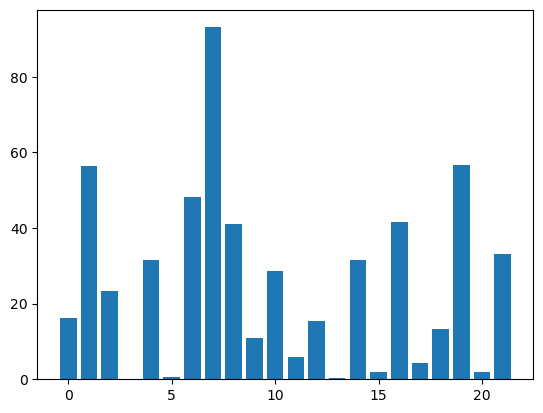

,Age,Height,Weight,Urination,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Visual Blurring,Irritability,Partial Paresis,Alopecia,gender_Female,gender_Male
78,47.0,171.11,92.010000,1.49,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,1
5,62.0,168.14,85.480000,2.65,0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0,1
502,55.0,174.21,68.450000,2.77,1,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0,1
176,47.0,157.29,49.020000,1.55,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0
111,40.0,162.26,60.680000,3.28,1,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,35.0,150.56,57.840000,3.30,0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1,0
201,36.0,167.33,69.542567,2.04,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
196,45.0,178.09,62.290000,1.75,1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,1
285,66.0,187.38,80.270000,1.61,0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0,1


In [30]:
from sklearn.feature_selection import SelectKBest, chi2
skb =  SelectKBest(chi2, k=15)
X_new = skb.fit_transform(X_train, y_train)

cols_idxs = skb.get_support(indices=True)
features_df_new = X_train.iloc[:,cols_idxs]



# what are scores for the features
for i in range(len(skb.scores_)):
 print(X_train.columns[i], ":", skb.scores_[i])
# plot the scores
plt.bar([i for i in range(len(skb.scores_))], skb.scores_)
plt.show()
features_df_new

Decision tree with depth=1. cv score: 0.7812966150315548
Decision tree with depth=2. cv score: 0.8414228341939186
Decision tree with depth=3. cv score: 0.879890992541595
Decision tree with depth=4. cv score: 0.9111302352266207
Decision tree with depth=5. cv score: 0.9207401032702236
Decision tree with depth=6. cv score: 0.9183878370625358
Decision tree with depth=7. cv score: 0.9135972461273665
Decision tree with depth=8. cv score: 0.8991107286288009
Decision tree with depth=9. cv score: 0.9040160642570282
Decision tree with depth=10. cv score: 0.913568559954102
Decision tree with depth=11. cv score: 0.9184452094090648
Decision tree with depth=12. cv score: 0.8990820424555365
Decision tree with depth=13. cv score: 0.9039013195639702
Decision tree with depth=14. cv score: 0.9087779690189329
Decision tree with depth=15. cv score: 0.9015490533562822
Decision tree with depth=16. cv score: 0.8991107286288009
Decision tree with depth=17. cv score: 0.8990820424555365
Decision tree with depth=

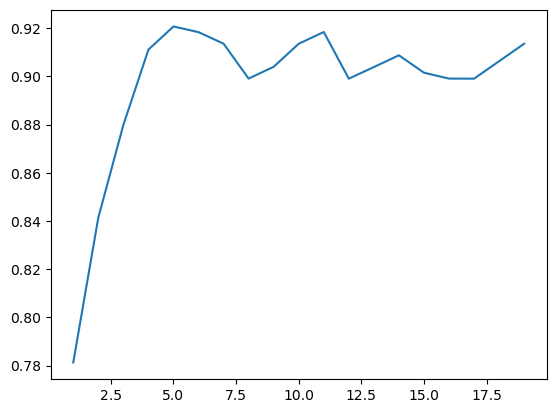

In [31]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

depths = list(range(1, 20))

scores = {}

"""
By weighing misslcassification more severly, we can minimze type II error,
which is desirable in the public health scenario. However, even with
a very skewed weighing (1-100), we still get missclassification,
indicatting that there are 'outliers' in the test set.

Further investigation revealed that they typically where quite old or quite young,
with a typical amount of urination.
"""
weight = {0: 1,
          1:1}

use_weights = False

for d in depths:
    clf_cv = tree.DecisionTreeClassifier(max_depth=d, class_weight=weight if use_weights else None)
    score = cross_val_score(clf_cv, X_train, y_train, cv=5).mean()
    scores[d] = score
    print(f'Decision tree with depth={d}. cv score: {score}')

print(scores.values())

plt.plot(scores.keys(), scores.values())

clf = tree.DecisionTreeClassifier(max_depth=7, class_weight=weight if use_weights else None)
clf = clf.fit(X_train, y_train)

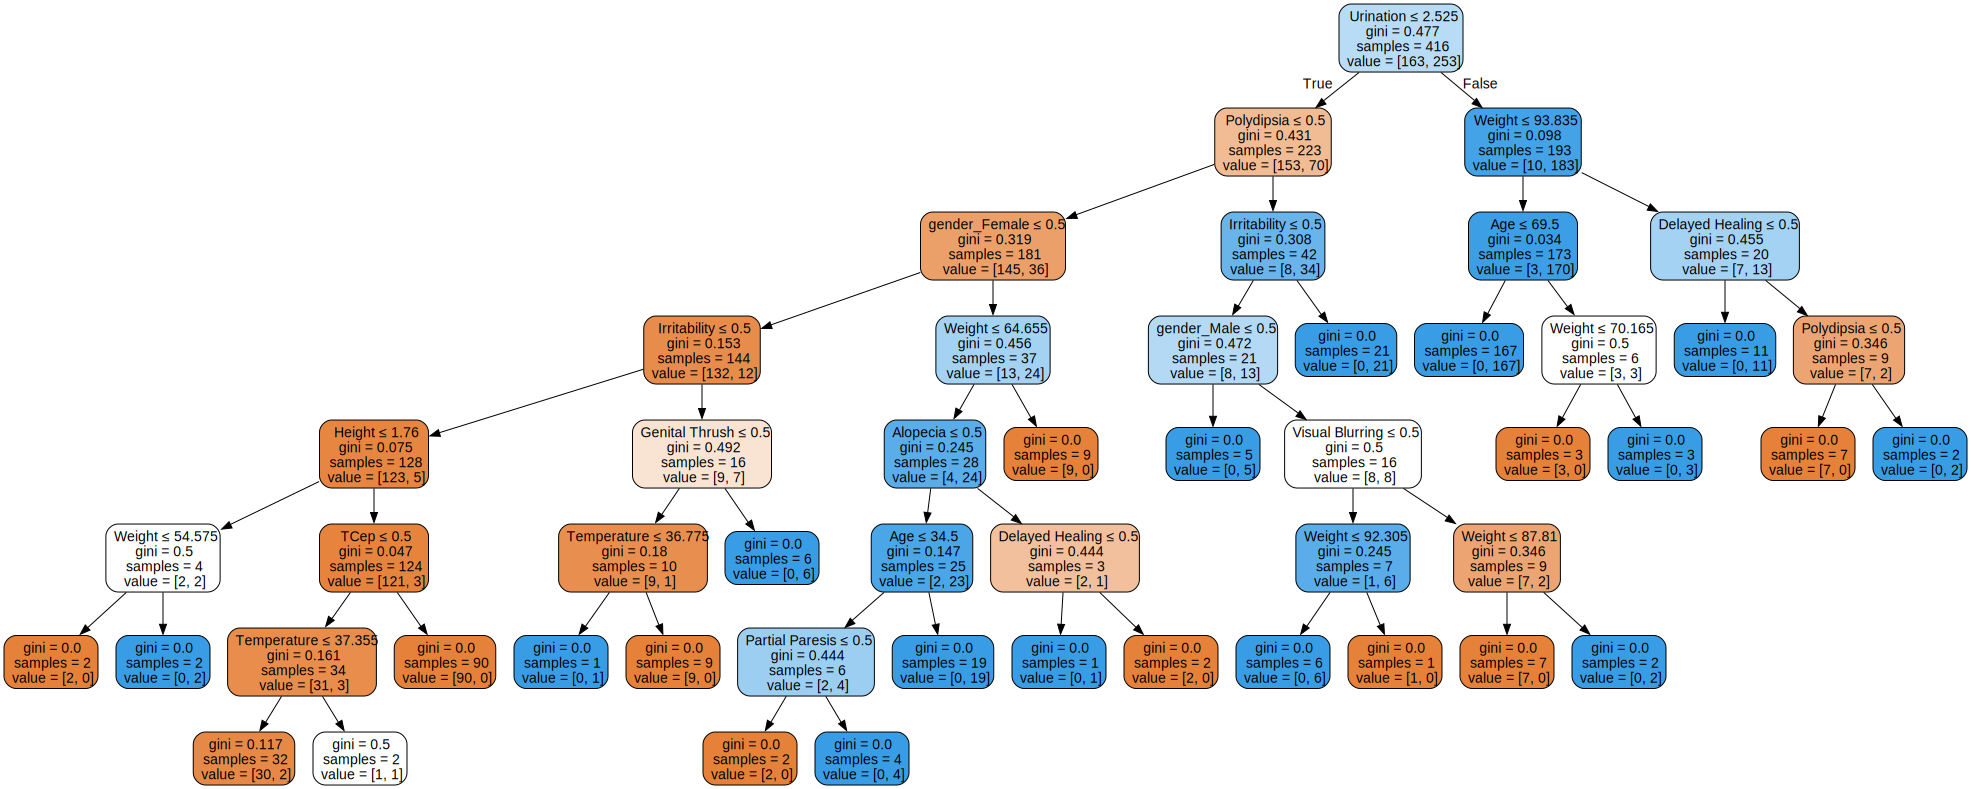

In [32]:
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None,
                      feature_names=selected_features,
                      #class_names='Diabetes', # this parameter doesen't seem to work
                      filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)
# Make Pdf
#graph.render("Diabetes")
graph

In [33]:
# Training accuracy
from sklearn import metrics
y_train_pred = clf.predict(X_train)
metrics.accuracy_score(y_train, y_train_pred)

0.9927884615384616

In [34]:
y_test_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_test_pred)

0.9038461538461539

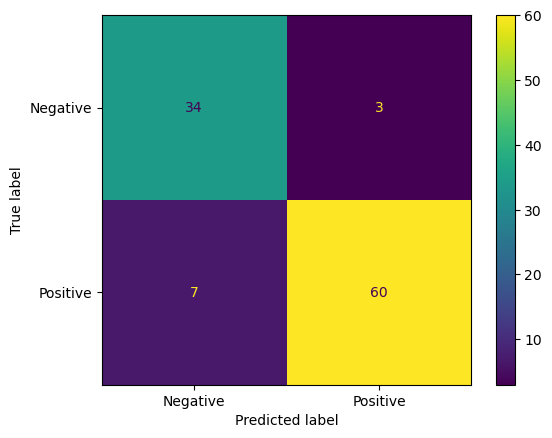

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_mat = metrics.confusion_matrix(y_test, y_test_pred)
con_mat_disp = ConfusionMatrixDisplay(confusion_mat, display_labels=clf.classes_)
con_mat_disp.plot()

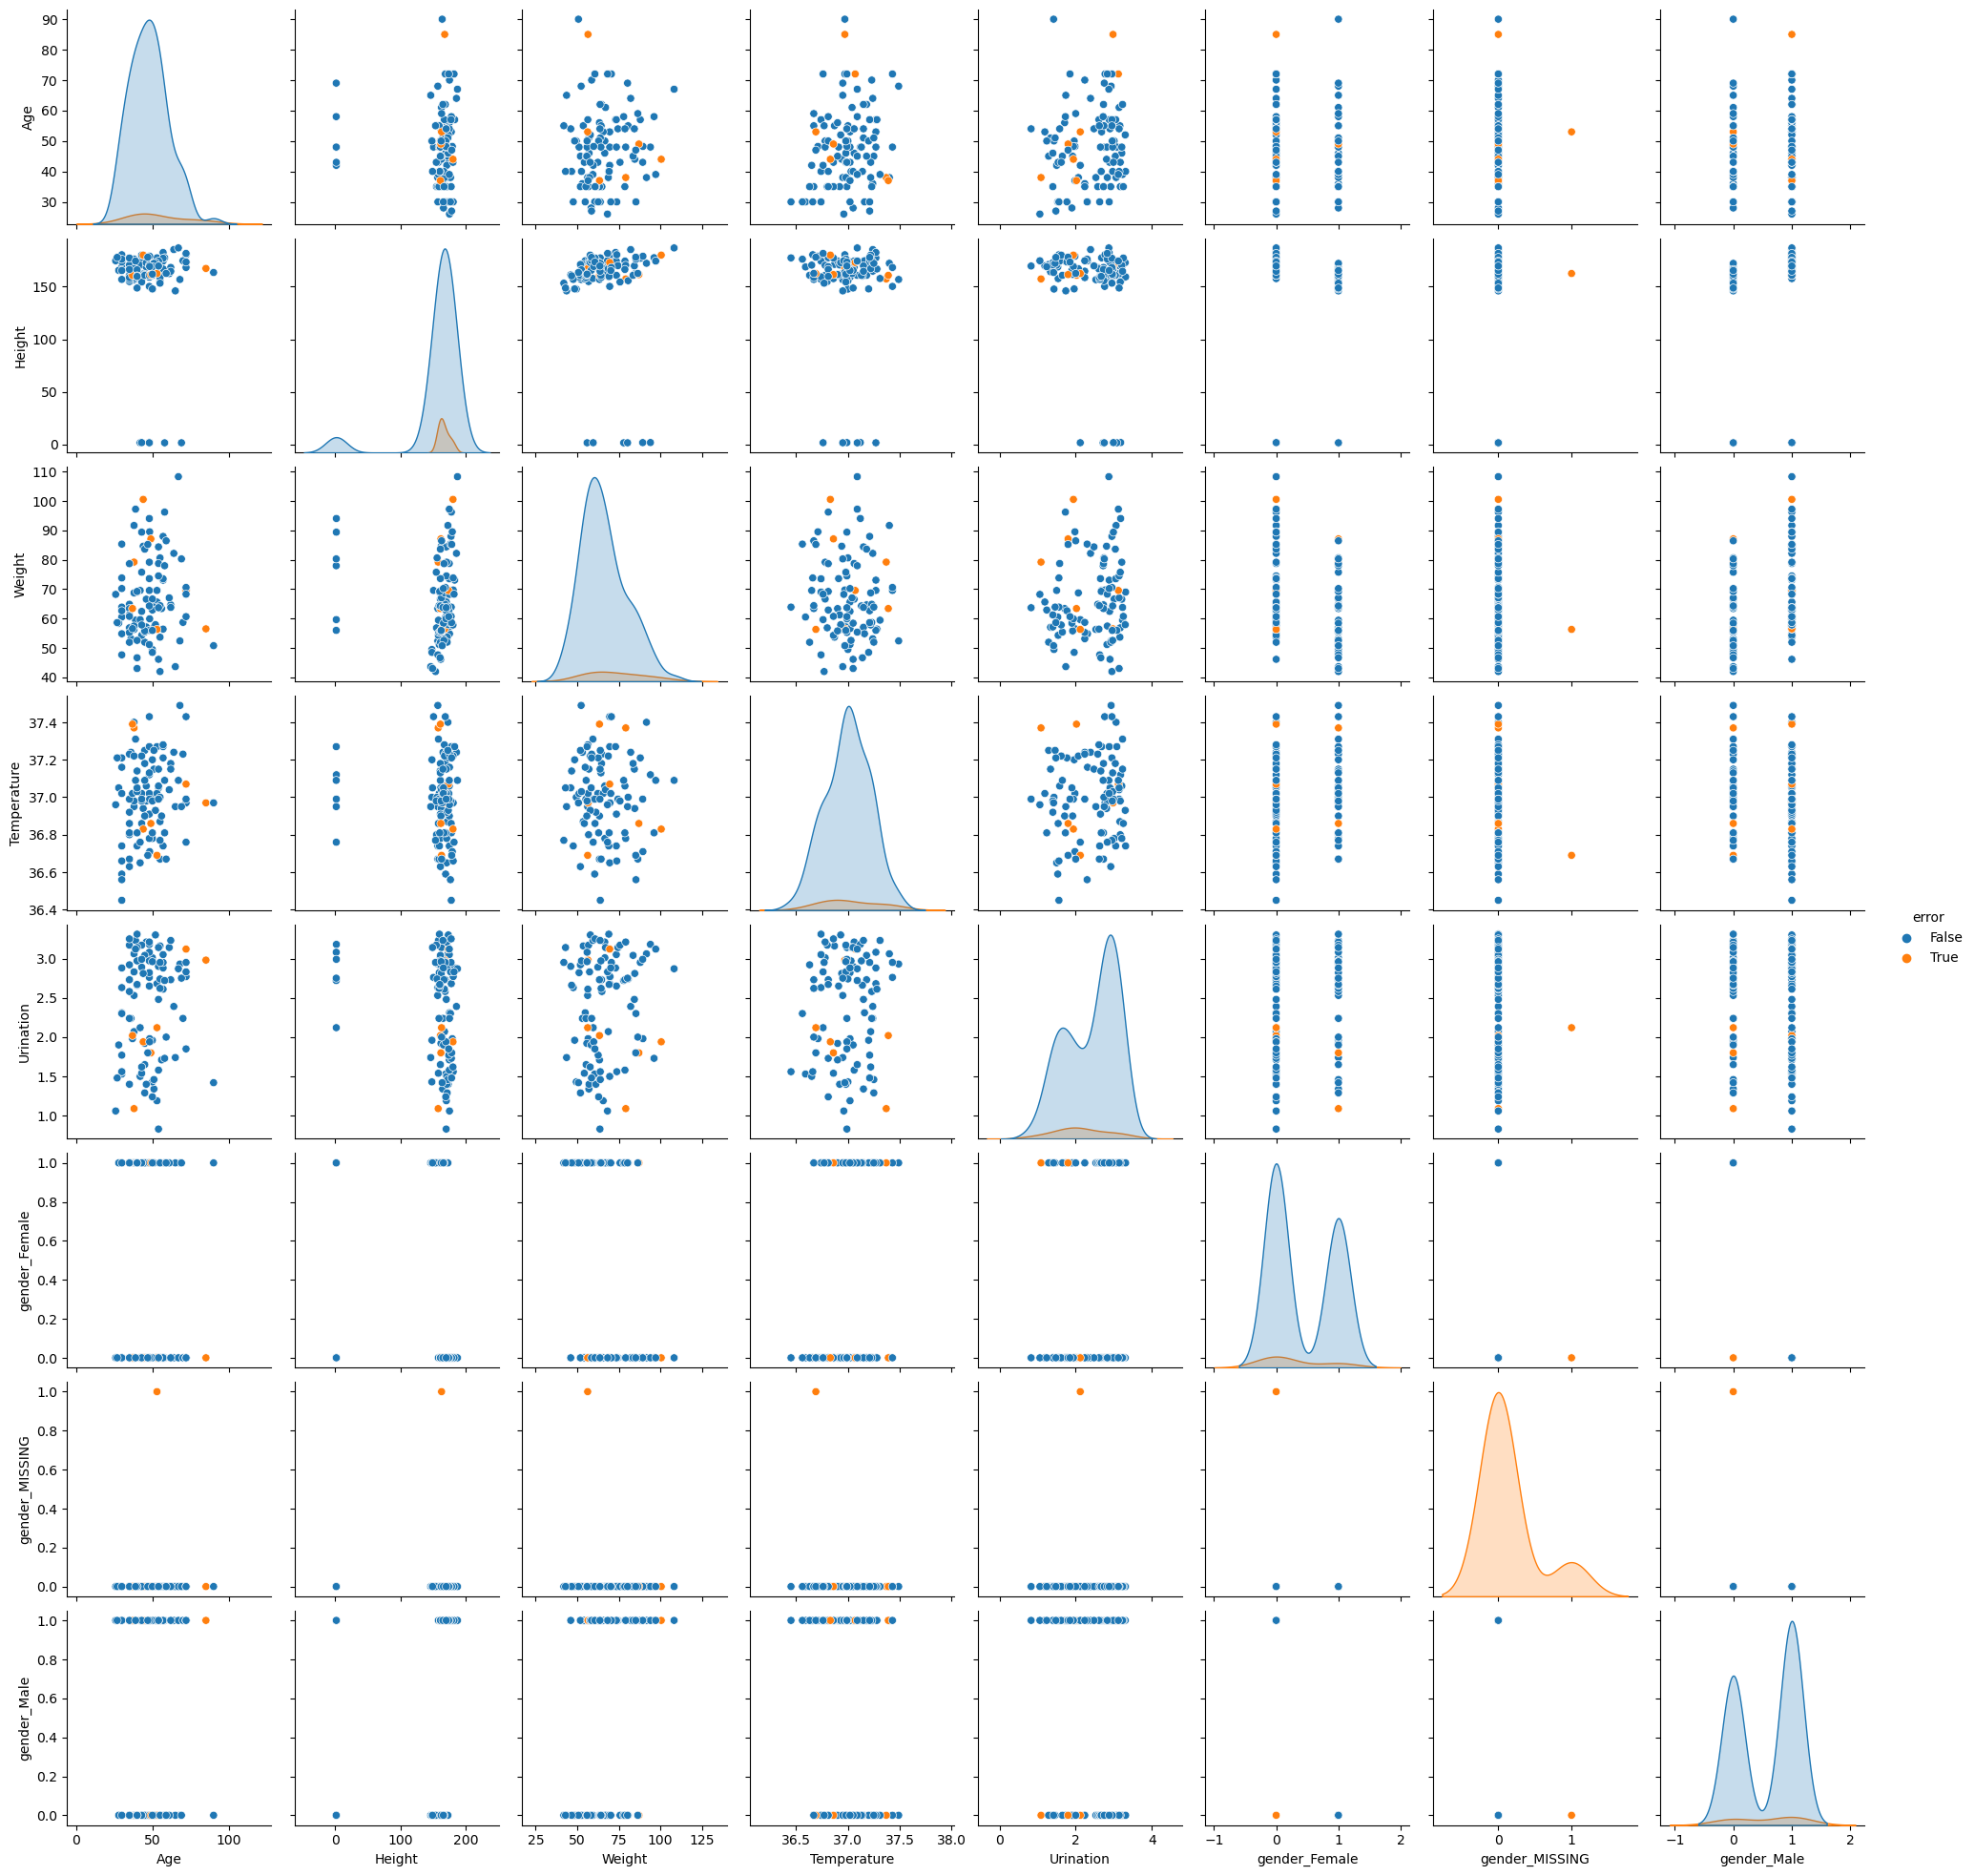

In [36]:
X_test_plot = X_test.copy()
X_test_plot['error'] = y_test > y_test_pred
g = sns.pairplot(X_test_plot.drop(binary_features, axis=1), hue='error')

Logistic regression with C = 10.00. cv score: 0.9206253585771659
Logistic regression with C = 7.85. cv score: 0.9206253585771659
Logistic regression with C = 6.16. cv score: 0.9206253585771659
Logistic regression with C = 4.83. cv score: 0.9206253585771659
Logistic regression with C = 3.79. cv score: 0.9206253585771659
Logistic regression with C = 2.98. cv score: 0.9206253585771659
Logistic regression with C = 2.34. cv score: 0.9206253585771659
Logistic regression with C = 1.83. cv score: 0.9206253585771659
Logistic regression with C = 1.44. cv score: 0.9206253585771659
Logistic regression with C = 1.13. cv score: 0.918215720022949
Logistic regression with C = 0.89. cv score: 0.9206253585771659
Logistic regression with C = 0.70. cv score: 0.9206253585771659
Logistic regression with C = 0.55. cv score: 0.9182444061962134
Logistic regression with C = 0.43. cv score: 0.9182444061962134
Logistic regression with C = 0.34. cv score: 0.9182444061962134
Logistic regression with C = 0.26. cv sc

KeyboardInterrupt: 

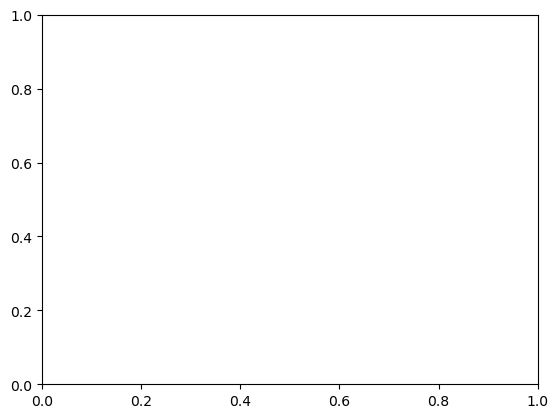

In [37]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', solver='liblinear', C=1000)

cs = 1/np.geomspace(0.1, 10, 20)

scores = {}


for c in cs:
    clf_cv = LogisticRegression(penalty='l2', solver='liblinear', C=c)
    score = cross_val_score(clf_cv, X_train, y_train, cv=5).mean()
    scores[d] = score
    print(f'Logistic regression with C = {c:.2f}. cv score: {score}')

print(scores.values())

plt.plot(scores.keys(), scores.values())



clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

# Accuracy
print(metrics.accuracy_score(y_test, y_test_pred))
print(clf.coef_)

# Confusion Matrix
confusion_mat = metrics.confusion_matrix(y_test, y_test_pred)
con_mat_disp = ConfusionMatrixDisplay(confusion_mat, display_labels=clf.classes_)
con_mat_disp.plot()


In [ ]:
metrics.accuracy_score(y_test, y_test_pred)

0.875